In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

from loaders import get_train_loader, get_val_test_loader, get_length_vocab, get_pad_index, get_vocab, show_image

from train import train, validate, val_visualize_captions

from model import EncoderDecoder


import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import wandb

In [6]:
data_dir = '../data/Images/'
captions_file = '../data/captions.txt'

input_size = (224,224)

transform_train = transforms.Compose(
[
transforms.Resize(input_size),  
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # Normalize with the mean
    std=[0.229, 0.224, 0.225]    # Normalize with the standard deviation
)
])

transform_val = transforms.Compose(
[
transforms.Resize(input_size),  
transforms.ToTensor(),
transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # Normalize with the mean
    std=[0.229, 0.224, 0.225]    # Normalize with the standard deviation
)
])

# Split data into train and test sets
df_captions = pd.read_csv(captions_file)
unique_images = df_captions['image'].unique()
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

train_df = df_captions[df_captions['image'].isin(train_images)]
val_df = df_captions[df_captions['image'].isin(val_images)]
test_df = df_captions[df_captions['image'].isin(test_images)]

pad_index = get_pad_index(data_dir=data_dir, dataframe=train_df, transform=transform_train)

vocab_train_df = get_vocab(data_dir=data_dir, dataframe=train_df, transform=transform_train)
vocab_val_df = get_vocab(data_dir=data_dir, dataframe=val_df, transform=transform_val)
vocab_test_df = get_vocab(data_dir=data_dir, dataframe=test_df, transform=transform_val)

# Create train, validation, and test data loaders
train_dataloader = get_train_loader(data_dir=data_dir, dataframe=train_df, transform=transform_train, batch_size=32, num_workers=1) # Batch size 32
val_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=val_df, transform=transform_val, batch_size=16, num_workers=1) # Batch size 16
test_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=test_df, transform=transform_val, batch_size=16, num_workers=1)

print(len(val_dataloader))

405


In [7]:
# Hyperparameters
embed_size = 312
hidden_size = 512
vocab_size_train = len(vocab_train_df)
num_layers = 2
learning_rate = 0.003
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
if device.type == "cuda":
    current_device = torch.cuda.current_device()
    print(f"Current GPU Device: {torch.cuda.get_device_name(current_device)}")

Current GPU Device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [9]:
# initialize model, loss etc
load_model = False
torch.backends.cudnn.benchmark = True

if load_model:
    model = EncoderDecoder(embed_size, hidden_size, vocab_size_train, num_layers).to(device)
    model.load_state_dict(torch.load('model_weights.py'))
    model.eval()
else:
    model = EncoderDecoder(embed_size, hidden_size, vocab_size_train, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # We apply weight decay that is L2 reg to prevent overfitting
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

c:\Users\Miguel\anaconda3\envs\Pytorch_2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Miguel\anaconda3\envs\Pytorch_2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# wandb.init(entity="imgcaption_dl_project", project="miguel-moral (imgcaption_dl_project)")
# wandb.config.embed_size = embed_size
# wandb.config.hidden_size = hidden_size
# wandb.config.vocab_size_train = vocab_size_train
# wandb.config.num_layers = num_layers
# wandb.config.learning_rate = learning_rate
# wandb.config.device = device
# #wandb.config.scheduler = scheduler

# wandb.watch(model)
# wandb.log({"Model": wandb.Graph(model)})
# wandb.log({"Optimizer": str(optimizer)})

Starting epoch 1...
Train Epoch: 1; Loss: 8.09088
Train Epoch: 1; Loss: 3.06678
Train set: Average loss: 3.321116736262337
Validation set: Average loss: 6.70386


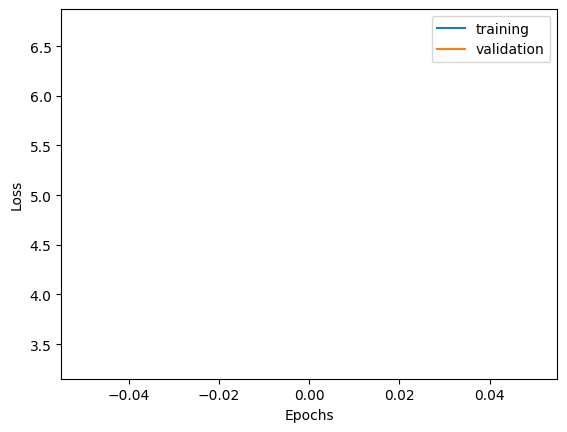

Starting epoch 2...
Train Epoch: 2; Loss: 2.81929
Train Epoch: 2; Loss: 2.77922
Train set: Average loss: 2.8380426302533803
Validation set: Average loss: 6.97444


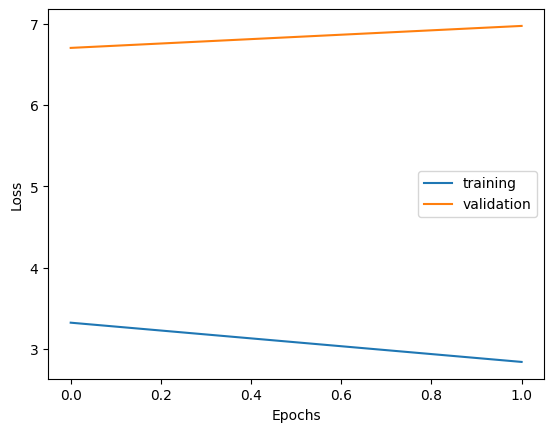

Starting epoch 3...
Train Epoch: 3; Loss: 2.57465
Train Epoch: 3; Loss: 2.63661
Train set: Average loss: 2.671533502371261
Validation set: Average loss: 7.19252


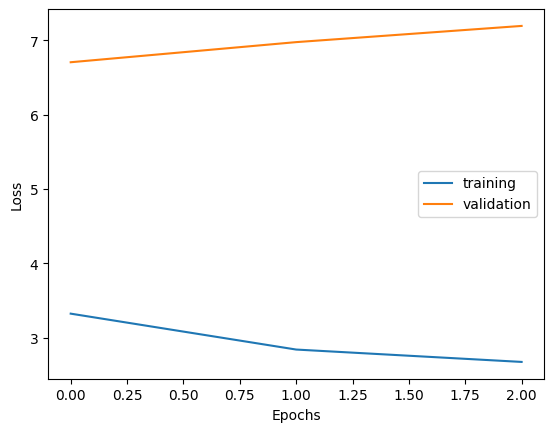

Starting epoch 4...
Train Epoch: 4; Loss: 2.52100
Train Epoch: 4; Loss: 2.41803
Train set: Average loss: 2.5570323962363677
Validation set: Average loss: 7.43471


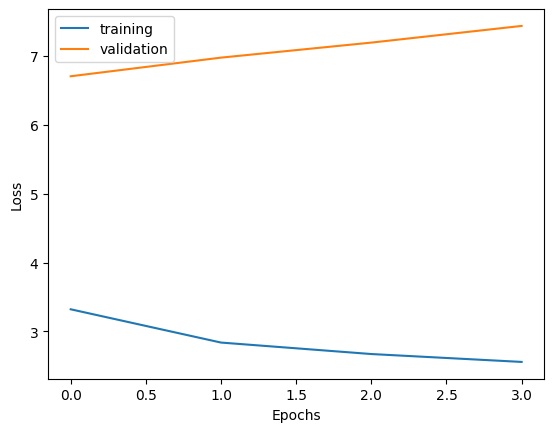

Starting epoch 5...
Train Epoch: 5; Loss: 2.53532
Train Epoch: 5; Loss: 2.40288
Train set: Average loss: 2.465892221783236
Validation set: Average loss: 7.71286


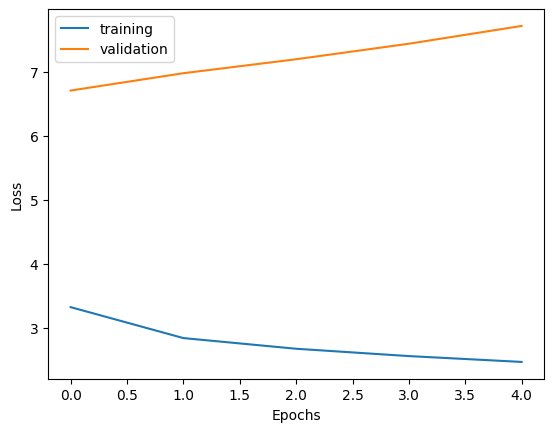

Starting epoch 6...
Train Epoch: 6; Loss: 2.42841
Train Epoch: 6; Loss: 2.32239


KeyboardInterrupt: 

In [10]:
### USING TRAIN AND VAL SEPARATED FUNCTIONS ONLY VISUALIZING LOSS VALUES FROM TRAINING AND VAL

losses = {"train": [], "val": []}
for epoch in range(50):
    print(f'Starting epoch {epoch + 1}...')
    
    train_loss = train(epoch, criterion, model, optimizer, train_dataloader, vocab_size_train, device)
    t_loss = sum(train_loss) / len(train_loss)
    print(f'Train set: Average loss: {t_loss}')
    val_loss = validate(criterion, model, val_dataloader, vocab_size_train, vocab_train_df, device)
    
    losses["train"].append(t_loss)
    losses["val"].append( val_loss.item() )    
    
    # wandb.log({"train_loss": train_loss, "val_loss": val_loss})
    
    plt.plot(losses["train"], label="training")
    plt.plot(losses["val"], label="validation")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# wandb.save('model_checkpoint.pth')

In [ ]:
torch.save(model.state_dict(), 'model_with_dropout.pt')

In [ ]:
# wandb.finish()

val_loss,▁▃▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████
Optimizer,Adam ( Parameter Gro...
val_loss,7.88102


In [ ]:
### USING A FUNCTION TO VISUALIZE THE CAPTIONS GENERATED IN VAL FROM THE TRAINING (WE TRAIN AGAIN AND VISALIZE THE CAPTIONS IN VAL, IT TAKES LONGER IF YOU JUST WANT TO TRAIN
# WE TRAIN AGAIN AND VISALIZE THE CAPTIONS IN VAL, IT TAKES LONGER IF YOU JUST WANT TO TRAIN RUN THE CELL ABOVE
val_visualize_captions(model, train_dataloader, val_dataloader, criterion, optimizer, device, vocab_size_train, vocab_train_df, 50)